**Escuela Colombiana de Ingeniería Julio Garavito**,
**Algorithms and data representation**,

**Homework # 1. Professor Cristian C. Garzón Alfonso**

Luis Felipe Díaz Chica - Master's degree student

   
#### How to run this notebook
* install python3 and pip
* then run:
`pip install -r requirements.txt`
* run `jupyter notebook`
* go to `localhost:8888`
* run this notebook cells

#### Proecedure to generate the data files

* Each of the following charts is using a data file generated from a mapreduce script that was executed in a local Hadoop cluster. 
* The input for all the mapreduce scripts was a file with tweets and retweets open data.
* For more information about the scripts fo to the `tweetswordcount` project in the root of this project.


In [46]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

    
def create_bubble_chart(words, count, title, separation=4, table=False, ):    

    def generate_colors(n):
        return ["#FF5733", "#FFF033", "#90FF33", "#33FF77", "#33FFE6", "#D133FF", "#FF3346", "#335EFF", "#858A9F", "#C8C46F", "#6FC897"][:n]
      
    
    colors =  generate_colors(len(words))    
    
    bubble_chart = BubbleChart(area=count,    
                               bubble_spacing=separation)    
    
    bubble_chart.collapse()    
    
    fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))    
    bubble_chart.plot(    
        ax, words, generate_colors(len(words)))    
    ax.autoscale_view()    
    
    ax.set_title(title)    
    
  
    plt.show()

    if table:
        data = [(count[i], words[i]) for i in range(len(words))]
        data = sorted(data, reverse=True)
        
        table={
            'cell_text': [[x[0]] for x in data],
            'row_labels': [x[1] for x in data],
            'column_headers': ['count']
        }
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)

        table = ax.table(cellText=table['cell_text'], 
                  rowLabels=table['row_labels'], colLabels=table['column_headers'], loc='center')
        table.set_fontsize(14)
        table.scale(1,2)
        ax.axis('off')

        plt.show()

## Count number of times the selected words appears  

**Selected words:** “TRUMP”, “DICTATOR”, “MAGA”, “IMPEACH”, “DRAIN”, “SWAP”, “CHANGE” appear on the tweet's text field

* The data for this was generated using the mapreduce script `AllowedWordsTweets.java`  found in the `tweetswordcound` folder.


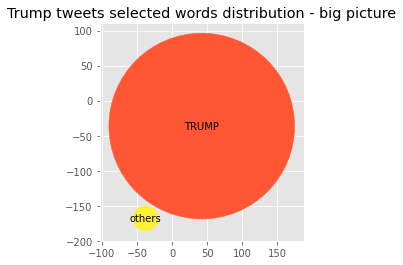

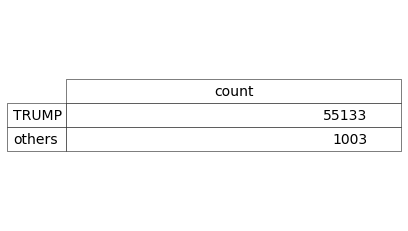

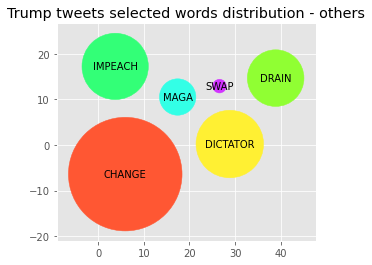

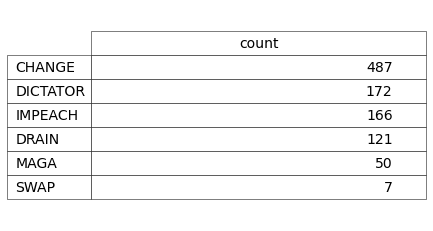

In [47]:
import random    

filename = "selectedWordsUpperCase"
def read_file_data(filename):
    with open(filename) as f:
        content = f.readlines()

    words = []
    count = []

    for line in content:
        try:
            line = line.strip()
            data = line.split("\t")
            words.append(data[0])
            count.append(int(data[1]))    
        except:
            continue
        
    return words, count

words, count = read_file_data(filename)

maxi = max(count)
others_total = sum(count) - maxi

count = list(filter(lambda x: x != maxi, count))
words = list(filter(lambda x: x != "TRUMP", words))
    

create_bubble_chart(["TRUMP", "others"],
                    [maxi, others_total], "Trump tweets selected words distribution - big picture", table=True)
create_bubble_chart(words, count, "Trump tweets selected words distribution - others", table=True)     


## Count number of times words appears  excluding stop words

* The data for this was generated using the mapreduce script `NonStopWordsTweets.java`  found in the `tweetswordcound` folder.

* [stop words](https://ocw.mit.edu/courses/sloan-school-of-management/15-071-the-analytics-edge-spring-2017/text-analytics/turning-tweets-into-knowledge-an-introduction-to-text-analytics/video-5-pre-processing-in-r/stopwords.txt) used


words 34853 34852


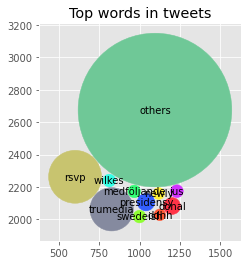

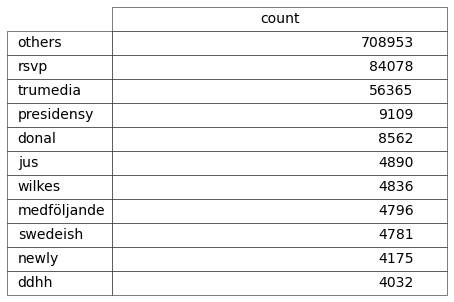

In [48]:
stop_names, stop_count = read_file_data("non-stop-2")
print("words", len(stop_names), len(stop_count))
data = [(stop_count[i], stop_names[i]) for i in range(len(stop_count))]
data = sorted(data)
others = data[:-10]
top = data[-10:]
top_names = [x[1] for x in top] + ["others"]
top_values = [x[0] for x in top] + [sum([x[0] for x in others])]

create_bubble_chart(top_names, top_values, "Top words in tweets", 5, table=True)

## Count the number of tweets by user

* The data for this was generated using the mapreduce script `CountUserTweets.java`  found in the `tweetswordcound` folder.

The user with more tweets is: TrumpDailyTweet with 83 tweets
Total distinct users that posted a tweet:  92547


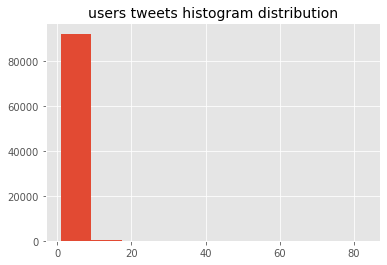

Its very hard to determine the tweets distribution using a histogram, let's group some of the data to have a better picture
99.87% of users posted less than 10 tweets
2066.67% of users posted more than 10 tweets
Still very hard to read the data


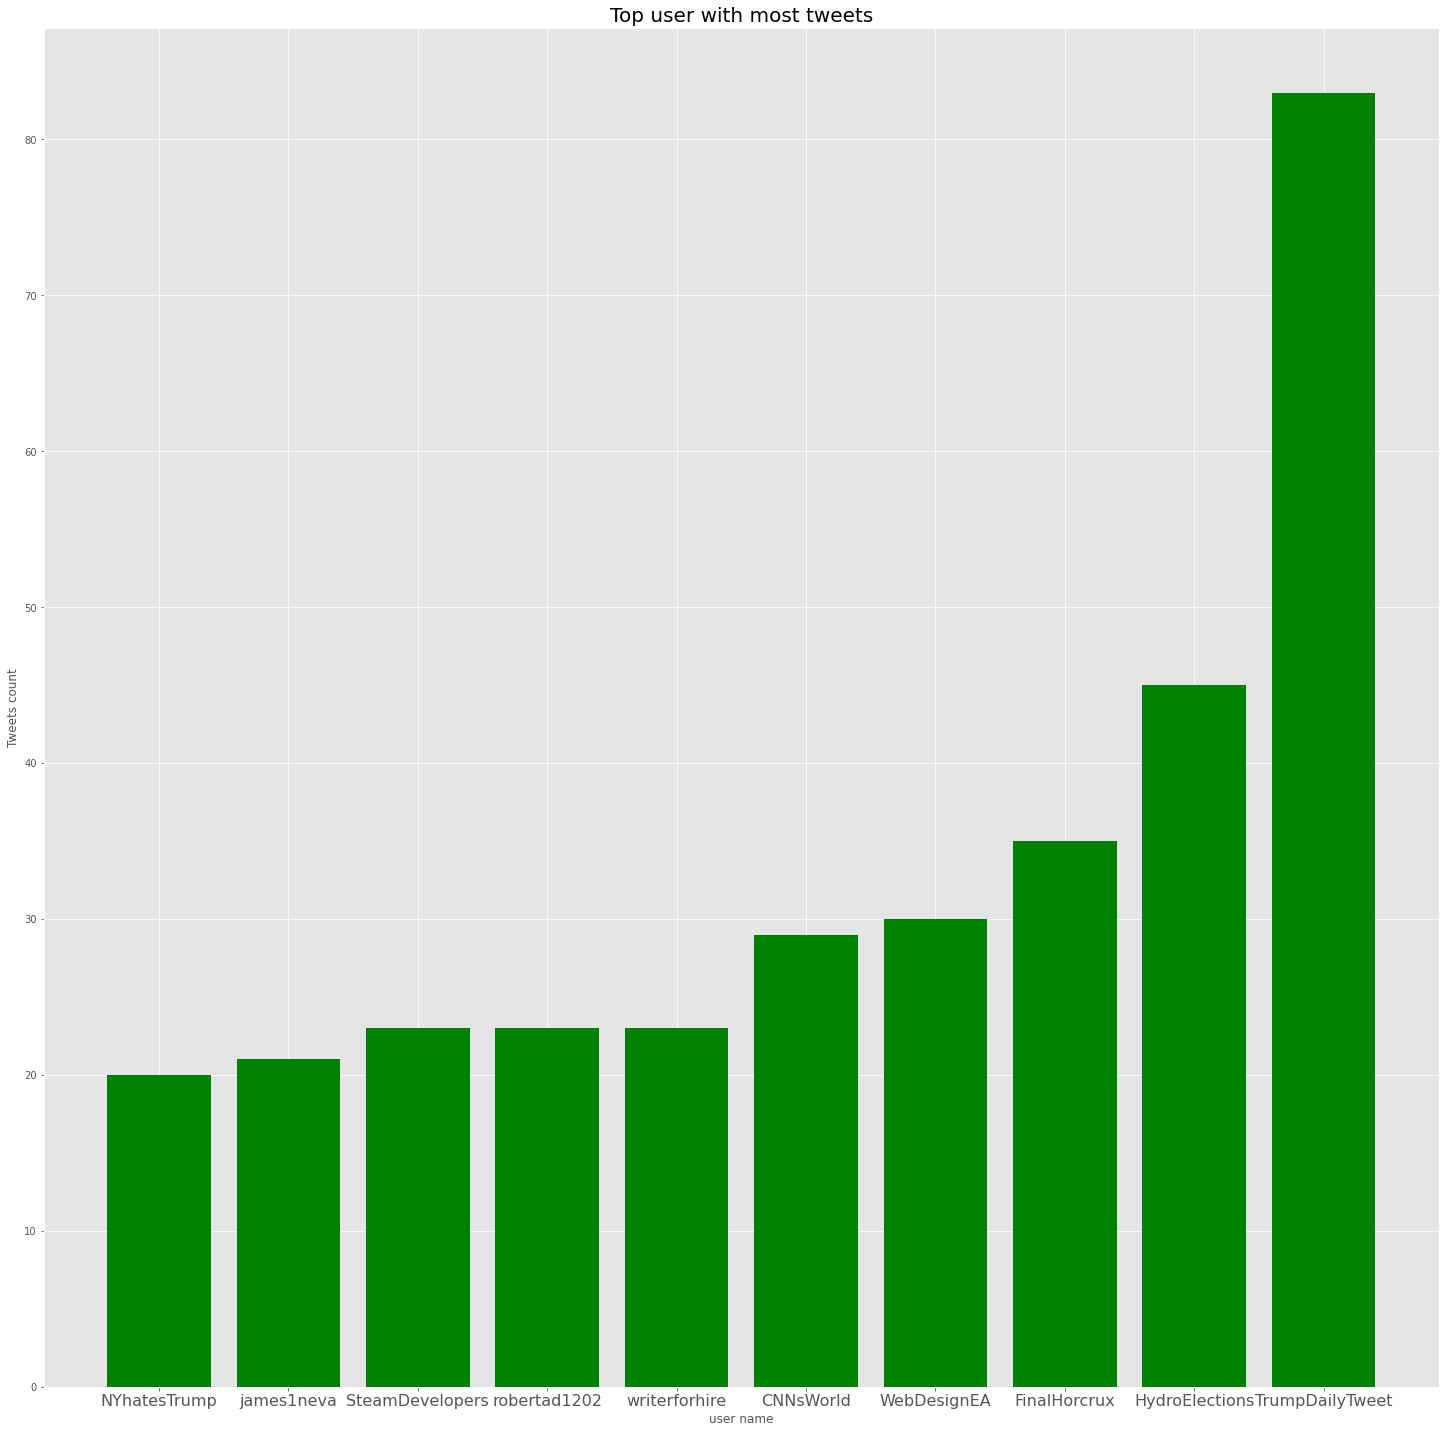

In [49]:
filename = "user-count-1"

users_name, tweets_count = read_file_data(filename)
users_data = [(tweets_count[i], users_name[i]) for i in range(len(users_name))]

maxi, maxi_i = 0,0
for i in range(len(users_name)):
    if tweets_count[i] > maxi:
        maxi, maxi_i = tweets_count[i], i

print("The user with more tweets is:", users_name[maxi_i], "with", maxi, "tweets")
print("Total distinct users that posted a tweet: ", len(users_name))
plt.hist(tweets_count)
plt.title("users tweets histogram distribution", fontsize=14)
plt.show()
print("Its very hard to determine the tweets distribution using a histogram, let's group some of the data to have a better picture")
count_g1 = list(filter(lambda x: x <= 10, tweets_count))
count_g2 = list(filter(lambda x: x > 10, tweets_count))

print( f'{round((len(count_g1)/len(users_name))*100, 2)}% of users posted less than 10 tweets')
print( f'{round((len(count_g2)/len(words))*100, 2)}% of users posted more than 10 tweets')
plt.show()
print("Still very hard to read the data")

top_users_names = sorted(users_data)[-10:]

names = [x[1] for x in top_users_names]
tweets_count = [x[0] for x in top_users_names]
pos = [i for i in range(len(names))]
plt.figure(figsize=(25,25))

plt.bar(pos, tweets_count, color='green')
plt.xlabel("user name")
plt.ylabel("Tweets count")
plt.title("Top user with most tweets", fontsize=20)
plt.xticks(pos, names, fontsize=16)
plt.show()


## Tweets by country

* The data for this was generated using the mapreduce script `ConutCountriesTweets.java`  found in the `tweetswordcound` folder.

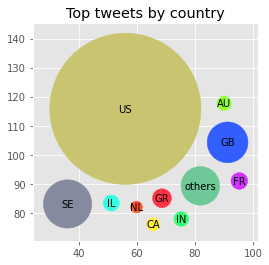

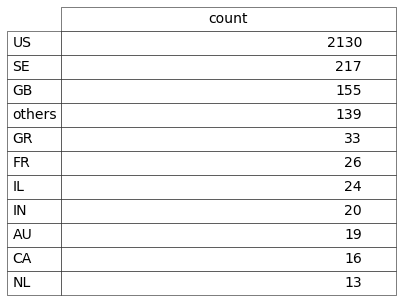

In [50]:
country_name, country_count = read_file_data("country-code-1")
data = [(country_count[i], country_name[i]) for i in range(len(country_name))]
data = sorted(data)
others = data[:-11]
top = data[-11:][:-1]
top_names = [x[1] for x in top] + ["others"]
top_values = [x[0] for x in top] + [sum([x[0] for x in others])]

create_bubble_chart(top_names, top_values, "Top tweets by country", table=True)


## Tweets by language

* The data for this was generated using the mapreduce script `CountLanguageTweets.java`  found in the `tweetswordcound` folder.

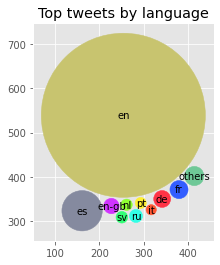

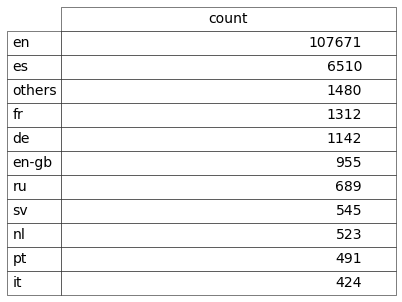

In [51]:
lang_name, lang_count = read_file_data("lang-count-1")
data = [(lang_count[i], lang_name[i]) for i in range(len(lang_name))]
data = sorted(data)
others = data[:-10]
top = data[-10:]
top_names = [x[1] for x in top] + ["others"]
top_values = [x[0] for x in top] + [sum([x[0] for x in others])]

create_bubble_chart(top_names, top_values, "Top tweets by language", table=True)
